In [1]:
"""
Purpose: 

To Determine which of the branches are 
potential axon candidates

"""

'\nPurpose: \n\nTo Determine which of the branches are \npotential axon candidates\n\n'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from os import sys
sys.path.append("/meshAfterParty/")

In [18]:
from importlib import reload

import neuron_utils as nru

import neuron

import neuron_visualizations as nviz

import time

import datajoint_utils as du

import numpy as np

import proofreading_utils as pru
import preprocessing_vp2 as pre

# Loading the Neuron Mesh

In [5]:
import trimesh_utils as tu
current_neuron_mesh = tu.load_mesh_no_processing("/notebooks/test_neurons/meshafterparty_processed/12345_double_soma_meshafterparty_9_29.off")


In [6]:
segment_id = 12345
description="classic_double_soma_12_29"
somas=None

In [10]:
total_neuron_process_time = time.time()

print(f"\n--- Beginning preprocessing of {segment_id}---")
recovered_neuron = neuron.Neuron(
mesh = current_neuron_mesh,
somas = somas,
segment_id=segment_id,
description=description,
suppress_preprocessing_print=False,
suppress_output=False,
calculate_spines=True,
widths_to_calculate=["no_spine_median_mesh_center"]

        )

print(f"\n\n\n---- Total preprocessing time = {time.time() - total_neuron_process_time}")


--- Beginning preprocessing of 12345---
--- 0) Having to preprocess the Neuron becuase no preprocessed data
Please wait this could take a while.....
Skipping the hole filling
use_meshafterparty = True
Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 5000.0 
large_mesh_threshold_inner = 5000.0 
soma_size_threshold = 937.5 
soma_size_threshold_max = 12000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
xvfb-run -n 1662 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_13179.off -o /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_13179_fill_holes.off -s /notebooks/Auto_Proofreading/Compartments/Axon/temp/fill_holes_549391.mls
removed temporary input file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_13179.off
removed temporary output file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_13179_fill_holes.off
/notebooks/Auto_Proofreading/Compartments/Axon/temp/f

xvfb-run -n 289 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner.off -o /notebooks/Auto_Proofreading/Compartments/Axon/12345/neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off -s /notebooks/Auto_Proofreading/Compartments/Axon/12345/decimation_meshlab_25932858.mls

-------Splits after inner decimation len = 1--------

done exporting decimated mesh: neuron_12345_decimated_largest_piece_poisson_largest_inner.off
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(10639, 3), faces.shape=(21274, 3))>

1) Starting: Mesh importing and Pymesh fix
loading mesh from vertices and triangles array
1) Finished: Mesh importing and Pymesh fix: 0.0007109642028808594
2) Staring: Generating CGAL segmentation for neuron
Done writing OFF file

Starting CGAL segmentation
Right before cgal segmentation, clusters = 3, smoothness = 0.2, path_and_filename = /

removed temporary input file: /notebooks/Auto_Proofreading/Compartments/Axon/Poisson_temp/neuron_948102.off
removed temporary output file: /notebooks/Auto_Proofreading/Compartments/Axon/Poisson_temp/neuron_948102_poisson.off
mesh.is_watertight = True
/notebooks/Auto_Proofreading/Compartments/Axon/Poisson_temp/poisson_129913.mls is being deleted....
Inside sphere validater: ratio_val = 243.70909586956054
--->This soma mesh was not added because it did not pass the sphere validation:
 soma_mesh = <trimesh.Trimesh(vertices.shape=(618, 3), faces.shape=(1229, 3))>, curr_side_len_check = True, curr_volume_check = False



 Total time for run = 214.6900863647461
Before Filtering the number of somas found = 2
Performing Soma Mesh Backtracking to original mesh
# total split meshes = 79
viable_meshes = [0]
There were 78 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0]}


----Working on soma-containing mesh piece 0----
current_soma_mesh_list =


Largest hole before segmentation = 296632.54401808785, after = 611533.4811623684,
ratio = 2.0615859368589, difference = 314900.9371442806
Skipping the segmentatio filter at end
removing mesh interior before segmentation
xvfb-run -n 1430 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_89949.off -o /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_89949_fill_holes.off -s /notebooks/Auto_Proofreading/Compartments/Axon/temp/fill_holes_953752.mls
removed temporary input file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_89949.off
removed temporary output file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_89949_fill_holes.off
/notebooks/Auto_Proofreading/Compartments/Axon/temp/fill_holes_953752.mls is being deleted....
xvfb-run -n 4204 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_67008.off -o /notebooks/Auto_Proofreading/Compartments/Axo


Largest hole before segmentation = 101868.505754373, after = 1043428.4149404205,
ratio = 10.242895065687447, difference = 941559.9091860475
Soma List = [<trimesh.Trimesh(vertices.shape=(20419, 3), faces.shape=(40531, 3))>, <trimesh.Trimesh(vertices.shape=(13928, 3), faces.shape=(27831, 3))>]
soma_mesh_list_centers = [array([756951.59392233, 958934.16523826, 874272.94729908]), array([863965.45847214, 994501.70777571, 859769.72105112])]
xvfb-run -n 2792 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_90213.off -o /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_90213_remove_interior.off -s /notebooks/Auto_Proofreading/Compartments/Axon/temp/remove_interior_30039.mls
removed temporary input file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_90213.off
removed temporary output file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/neuron_90213_remove_interior.off
/notebooks/Auto_Proofreading/Compartments/A

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.38s/it]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 4.73781418800354
connecting at the root
branches_touching_root = [60]
length of Graph = 15706
Working on path [7923. 7950. 7993. 8001.]
path_degrees = [3, 2, 2, 3]
After combining close endpoints max(kept_branches_idx) = 60, len(kept_branches_idx) = 60
empty_indices % = 0.0
 conflict_indices % = 0.013085916550466588



AFTER face_lookup_resolved_test



Decomposing first pass: 15.125329971313477
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [15744, 1763, 9025, 4845, 5632, 2392, 2951, 1984, 2287, 4216, 11544, 11107, 7851, 15941, 4556, 10056, 15273, 656, 214, 7932, 1007, 2607, 12828, 896, 8848, 11432, 11086, 4672, 2777, 2614, 9875, 2520, 2258, 7367, 10491, 12961, 15420, 15989, 3327]
mesh_large_connectivity: 1.8949849605560303
Finding MAP candidates connected components: 0.0003948211669921875
len(filtered_pieces) = 2
skeleton_connectivity_MP : 0.23841214179992676
Grouping MP Sublimbs by Graph: 0.0344233512878418
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.016570568084716797
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
The mesh passed has 21 pieces so just taking the largest one <trimesh.Trimesh(vertices.shape=(135479, 3), faces.


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.30406880378723145
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 125.42802405357361
Checking connected components after removing cycles
Total time for mesh KDTree = 1.7069149017333984
sbv[0].reshape(-1,3) = [[757248.8 949474.6 871715.8]]
closest_sk_pt_coord BEFORE = [756851. 948250. 874012.]
current_skeleton.shape = (9301, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [756851. 948250. 874012.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[756851., 948250., 874012.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 9.47258996963501
filter_end_node_length = 4500
Using Distance measure skeletal_distance
endpoints_must_keep = [[756851. 948250. 874012.]]
Number of end_nodes BE


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (7626, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 2 valid paths to replace
valid_paths = [array([2398., 2402., 2404., 2410.]), array([3953., 3989., 3995., 4016., 4037.])]
valid_path_lengths = [508.43061225433075, 442.8068275214607]
length of Graph = 7624
Working on path [2398. 2402. 2404. 2410.]
path_degrees = [3, 2, 2, 3]
Working on path [3953. 3989. 3995. 4016. 4037.]
path_degrees = [3, 2, 2, 2, 3]
node_degrees = [2 2 2 2 2 2 2 2 2 4]
node_degrees = [2 4 2 2 2]
skeletonize_and_clean_connected_branch_CGAL: 196.4220893383026
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 35.1033821105957
mesh_correspondence_first_pass: 35.10340595245361
Limb decomposed into 25 branches
divided_skeleton_graph_recovered = (7603, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (7603, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (24, 25)
empty_indices % = 0.10023218958463863
 conflict_indices % = 0.026329561788228355



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 256.5663583278656
correspondence_1_to_1: 25.024173736572266
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.0024220943450927734
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
The mesh passed has 6 pieces so just taking the largest one <trimesh.Trimesh(vertices.shape=(1834, 3), faces.shape=(3609, 3))>
     Starting Screened Poisson
xvfb-run -n 4449 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off -o /notebooks/Auto_Proofreading/Compartments/Axon/temp/None_poisson.off -s /notebooks/Auto_Proofreading/Compartments/Axon/temp/poisson_984294.mls
removed temporary input file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off
removed temporary output file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 3840 -s "-screen 0 800x600x24" meshlabserver $@


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.025708675384521484
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 7.008430480957031
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.007148265838623047
filter_end_node_length = 4500
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (149, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 7.244240760803223
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 0.3417534828186035
mesh_correspondence_first_pass: 0.34178924560546875
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (149, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (149, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.17653569452130602
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 7.797586917877197
correspondence_1_to_1: 0.20922446250915527
Total time for MAP sublimb processing 264.3644003868103
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0077152252197265625
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.003977298736572266
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.003114938735961914
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0006513595581054688
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.08987373112156474
 conflict_indices % = 0.0007922753156721961



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.09693633317376735
 conflict_indices % = 0.0013403542364767832



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 70978.80114713497
sk_conn = [0]
conn = [0]
winning_vertex = [617390.70637528 991940.3493018  899977.64549628]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (427.3724243636415) 
Found winning edge: [108, 109.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.09923385625684057
 conflict_indices % = 0.0005051497207644599



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10460412251974571
 conflict_indices % = 0.0007705644384511655



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [790061.79614569 913366.61359468 806307.92985623]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [19]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (626.4183147403959) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (666.0299170211457) 
Found winning edge: [105, 108.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1035650623885918
 conflict_indices % = 0.0020796197266785502



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 5052.273817845113
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [747692.98035346 833423.71748216 837836.37753604]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (997.2676023623447) 
Found winning edge: [172, 174.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (953.3001771561227) 
Found winning edge: [11, 12.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.1812792511700468
 conflict_indices % = 0.003536141445657826



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.17809174952032095
 conflict_indices % = 0.00898308041165184



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (3, 0) 




---- Working on (5, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 745.2822105348733
sk_conn = [1, 2]
conn = [1, 2]
winning_vertex = [ 562225.09974601 1021597.93209883  901754.6503269 ]
MP_branches_with_stitch_point = [1, 2]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (513.4545345485486) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (521.4459522363408) 
Found winning edge: [27, 28.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.10527943108912421
 conflict_indices % = 0.00440596738038185



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.1286503102407924
 conflict_indices % = 0.01428815392497296



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [1, 2]
MP_branches_for_correspondence = [1 2]
MP_leftover = [], MP_leftover_idx = []
 Finished with (5, 0) 




---- Working on (6, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1140.4158382153275
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [750225.42003372 832265.31151481 843305.46652016]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1637.1030563736717) 
Found winning edge: [259, 260.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1682.6899941565107) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.11176727909011373
 conflict_indices % = 0.016185476815398076



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.14184727002139336
 conflict_indices % = 0.017021672402567203



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (6, 0) 




---- Working on (7, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 26980.039697567456
sk_conn = [0]
conn = [0]
winning_vertex = [769842.41477881 965735.55265003 825802.66754091]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [23]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [242, 243.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.12381519796349455
 conflict_indices % = 0.0013540594702919353



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1297879876536963
 conflict_indices % = 0.005363558164246319



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (7, 0) 




---- Working on (8, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 10519.48004148061
sk_conn = [0]
conn = [0]
winning_vertex = [789461.38211197 884911.95391546 822530.9200346 ]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [24]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (579.6409311903394) 
Found winning edge: [189, 192.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.1673884077281812
 conflict_indices % = 0.002831445702864757



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.20855096254290403
 conflict_indices % = 0.005073869571705716



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (8, 0) 




---- Working on (9, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 18952.076744729813
sk_conn = [0]
conn = [0]
winning_vertex = [740556.37017036 948033.81589711 881349.96314501]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (647.9013980846263) 
Found winning edge: [2, 4.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.07426515511506347
 conflict_indices % = 0.0014934491887855542



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.09304255066966931
 conflict_indices % = 0.006459642052862392



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (9, 0) 




---- Working on (11, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 46549.982236340235
sk_conn = [0]
conn = [0]
winning_vertex = [657474.18915944 977164.3791609  892020.67095013]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [26]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [166, 167.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.10364023833340581
 conflict_indices % = 0.00043491497412255904



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11945994747209455
 conflict_indices % = 0.003980630334865397



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (11, 0) 




---- Working on (12, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6236.759837130087
sk_conn = [0]
conn = [0]
winning_vertex = [707076.07728256 963268.4837509  886392.52779786]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (507.7073671406673) 
Found winning edge: [617, 618.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.07112049187849867
 conflict_indices % = 0.001284757272643847



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.08034006376195536
 conflict_indices % = 0.006659582004959263



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (12, 0) 




---- Working on (13, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 7691.272820712564
sk_conn = [0]
conn = [0]
winning_vertex = [759831.41102267 918528.04973866 862768.90971417]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [16]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1124.1487168857964) 
Found winning edge: [20, 23.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.013387935107891007
 conflict_indices % = 0.0026775870215782014



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04308510638297872
 conflict_indices % = 0.016356382978723404



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (13, 0) 




---- Working on (14, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 11455.961565286396
sk_conn = [0]
conn = [0]
winning_vertex = [767602.56945079 955227.28259985 825444.88054069]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [23]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (409.6648648624075) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.17134680736898586
 conflict_indices % = 0.003219459846181363



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1966772151898734
 conflict_indices % = 0.010759493670886076



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (14, 0) 




---- Working on (4, 1) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [ 545002.20237731 1035355.15894395  907209.72201172]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (560.9800273605266) 
Found winning edge: [81, 82.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (558.65272828462) 
Found winning edge: [399, 400.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.15724177726485863
 conflict_indices % = 0.005770340450086555



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (4, 1) 




---- Working on (5, 1) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 2]
conn = [0, 2]
winning_vertex = [ 559655.79623005 1024226.6265392   901938.49994124]
MP_branches_with_stitch_point = [0, 2]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (594.3128108543906) 
Found winning edge: [127, 134.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (717.6438761252638) 
Gettng rid of 1 nodes INSIDE SKELETON TO GRAPH CONVERSION





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.24094835508178644
 conflict_indices % = 0.004227164124241867



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 2]
MP_branches_for_correspondence = [0 2]
MP_leftover = [], MP_leftover_idx = []
 Finished with (5, 1) 




---- Working on (10, 1) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 5067.678038784198
sk_conn = [0]
conn = [0]
winning_vertex = [ 549141.11248633 1032480.03600108  905834.7668478 ]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (319.40879092689687) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.1831218974076117
 conflict_indices % = 0.002206287920573635



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.15316858331294347
 conflict_indices % = 0.005382921458282359



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (10, 1) 



Time for decomp of Limb = 375.9101769924164
Number of matching vertices = 108
Only one endpoint after filtering away the endpoints that are not on the skeleton
Using Distance measure skeletal_distance
endpoints_must_keep = [array([756851., 948250., 874012.])]
Number of end_nodes BEFORE filtering = 33
all_single_nodes_to_eliminate = [22]



Removed 1 skeletal branches



307659 307660
For marked faces: None
empty_indices % = 0.0001852694532925957
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test





----- Working on Proper Limb # 1 ---------
meshparty_segment_size = 100
root_curr = [764613.6 961026.9 879448.1]
Time for preparing soma vertices and root: 0.0002803802490234375
invalidation_d = 12000
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 2.4944217205047607
branches_touching_root = [13]
length of Graph = 10874
Working on path [6621. 6628. 6630. 6635. 6638. 6640.]
path_degrees = [3, 2, 2, 2, 2, 3]
Working on path [10874.  6651.  6662.]
path_degrees = [4, 2, 3]
After combining close endpoints max(kept_branches_idx) = 44, len(kept_branches_idx) = 43
empty_indices % = 0.0
 conflict_indices % = 0.010926817059713548



AFTER face_lookup_resolved_test



Decomposing first pass: 11.741755485534668
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [5518, 17879, 1993, 5611, 8248, 158, 4250, 1122, 292, 1760, 11617, 5396, 4931, 4844, 7298, 3335, 752, 2756, 21110, 338, 1652, 13132, 12498]
mesh_large_connectivity: 0.6137924194335938
Finding MAP candidates connected components: 0.0002841949462890625
len(filtered_pieces) = 2
skeleton_connectivity_MP : 0.21240735054016113
Grouping MP Sublimbs by Graph: 0.03681468963623047
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.010226964950561523
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
The mesh passed has 17 pieces so just taking the largest one <trimesh.Trimesh(vertices.shape=(42585, 3), faces.shape=(85214, 3))>
     Starting Screened Poisson
xvfb-run -n 1051 -s "-screen 0 800x600x24" meshlabserve


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.1557316780090332
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 38.31535053253174
Checking connected components after removing cycles
Total time for mesh KDTree = 0.5736136436462402
sbv[0].reshape(-1,3) = [[856160.1 995780.8 859904.1]]
closest_sk_pt_coord BEFORE = [855834. 995971. 860546.]
current_skeleton.shape = (3552, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [855834. 995971. 860546.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[855834., 995971., 860546.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 1.8897626399993896
filter_end_node_length = 4500
Using Distance measure skeletal_distance
endpoints_must_keep = [[855834. 995971. 860546.]]
Number of end_nodes BE


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (3339, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 1 valid paths to replace
valid_paths = [array([2569., 2568., 2570., 2575.])]
valid_path_lengths = [528.1041698414045]
length of Graph = 3339
Working on path [2569. 2568. 2570. 2575.]
path_degrees = [3, 2, 2, 3]
node_degrees = [4 2 2 2 2 2]
skeletonize_and_clean_connected_branch_CGAL: 53.28012037277222
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 20.000459671020508
mesh_correspondence_first_pass: 20.00049066543579
Limb decomposed into 5 branches
divided_skeleton_graph_recovered = (3330, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (3330, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.10484571160389534
 conflict_indices % = 0.009386366302944973



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 83.43613648414612
correspondence_1_to_1: 10.145371675491333
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.007718801498413086
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
The mesh passed has 9 pieces so just taking the largest one <trimesh.Trimesh(vertices.shape=(25375, 3), faces.shape=(50914, 3))>
     Starting Screened Poisson
xvfb-run -n 8151 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off -o /notebooks/Auto_Proofreading/Compartments/Axon/temp/None_poisson.off -s /notebooks/Auto_Proofreading/Compartments/Axon/temp/poisson_735198.mls
removed temporary input file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off
removed temporary output file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 1715 -s "-screen 0 800x600x24" meshlabserver $


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.07873988151550293
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 27.076490879058838
Checking connected components after removing cycles
Total time for mesh KDTree = 0.3646669387817383
sbv[0].reshape(-1,3) = [[764613.6 961026.9 879448.1]]
closest_sk_pt_coord BEFORE = [764892. 961723. 878964.]
current_skeleton.shape = (1817, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [764892. 961723. 878964.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[764892., 961723., 878964.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.8733808994293213
filter_end_node_length = 4500
Using Distance measure skeletal_distance
endpoints_must_keep = [[764892. 961723. 878964.]]
Number of end_nodes 


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (1588, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 31.316494941711426
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 6.791340589523315
mesh_correspondence_first_pass: 6.791527509689331
Limb decomposed into 5 branches
divided_skeleton_graph_recovered = (1588, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1588, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.11077726719296178
 conflict_indices % = 0.01714386709084482



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 44.00713038444519
correspondence_1_to_1: 5.891381740570068
Total time for MAP sublimb processing 127.44399166107178
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.018149137496948242
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.014469385147094727
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.018901824951171875
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.01593494415283203
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10853543421434796
 conflict_indices % = 0.00043566656985187334



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 7199.385019803611
sk_conn = [0]
conn = [0]
winning_vertex = [ 834608.55858259 1008537.23536733  858132.74481039]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (684.0420002432481) 
Found winning edge: [140, 141.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.06962836394703119
 conflict_indices % = 0.0070482699700982485



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.111796785304248
 conflict_indices % = 0.039322617680826635



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 21031.611233846805
sk_conn = [0]
conn = [0]
winning_vertex = [ 810776.71389258 1017836.3378414   850877.39501258]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (522.7128704363495) 
Found winning edge: [164, 165.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.10574927592419439
 conflict_indices % = 0.00027366644621314054



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10629314389116011
 conflict_indices % = 0.0009382749145499631



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 36911.986182333305
sk_conn = [0]
conn = [0]
winning_vertex = [ 654119.39052006 1066395.03675066  847426.64592048]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (318.1441926141118) 
Found winning edge: [254, 257.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.11939312307809602
 conflict_indices % = 0.00022872245800401535



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.13444945582900283
 conflict_indices % = 0.0011030493185606432



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 78537.24156998456
sk_conn = [0]
conn = [0]
winning_vertex = [ 740875.60521871 1038687.52217102  839831.25998153]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [12, 13.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.12284794613590054
 conflict_indices % = 0.000295307562826684



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1227756965581831
 conflict_indices % = 0.020516272535705923



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1448.0622034734918
sk_conn = [0, 1, 2]
conn = [0, 1, 2]
winning_vertex = [ 812666.45561609 1017316.94860585  850507.38782781]
MP_branches_with_stitch_point = [0, 1, 2]
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (304.77931984751905) 
Found winning edge: [0, 2.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (618.3721113290264) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (607.771159582519) 
Found winning edge: [44, 46.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.171477442805217
 conflict_indices % = 0.0027795595467179817



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.1699537750385208
 conflict_indices % = 0.009399075500770416



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0, 1, 2]
MP_branches_for_correspondence = [0 1 2]
MP_leftover = [], MP_leftover_idx = []
 Finished with (5, 0) 




---- Working on (7, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 3339.3268138836493
sk_conn = [1]
conn = [1]
winning_vertex = [ 844554.17994661 1000961.75317652  861608.75604605]
MP_branches_with_stitch_point = [1]
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (460.9871643054035) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.09206349206349207
 conflict_indices % = 0.004329004329004329



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.16810750663357016
 conflict_indices % = 0.031241975519986306



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [1]
MP_branches_for_correspondence = [1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (7, 0) 




---- Working on (8, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 38815.69455421581
sk_conn = [0]
conn = [0]
winning_vertex = [ 777467.28879304 1027851.604918    844537.04498641]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [43, 44.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.09649781113195748
 conflict_indices % = 0.00075046904315197



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1030527401832858
 conflict_indices % = 0.0021241730897614856



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (8, 0) 




---- Working on (11, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 12862.326169237438
sk_conn = [0]
conn = [0]
winning_vertex = [ 751852.71606945 1034781.42029594  841826.78472209]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (865.1534004129668) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.10890079061463913
 conflict_indices % = 0.0045906656465187455



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11837029893924783
 conflict_indices % = 0.005544840887174542



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (11, 0) 




---- Working on (1, 1) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1107.8385617927433
sk_conn = [0]
conn = [0]
winning_vertex = [ 820762.89202273 1006986.27176105  862526.87194537]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (601.7255764337608) 
Found winning edge: [8, 9.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.1394658753709199
 conflict_indices % = 0.005267062314540059



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.16021636937343037
 conflict_indices % = 0.013716272779960076



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 1) 




---- Working on (6, 1) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 10016.748151377766
sk_conn = [0]
conn = [0]
winning_vertex = [808492.72167126 969524.95129816 863685.18721981]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (788.4200085884111) 
Found winning edge: [142, 143.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.10160132523467698
 conflict_indices % = 0.004417448923246825



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10464658397322307
 conflict_indices % = 0.01535735380980508



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (6, 1) 




---- Working on (9, 1) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 24917.284760082985
sk_conn = [0]
conn = [0]
winning_vertex = [ 795965.90298399 1005413.97155279  865087.47016204]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (340.73959651500246) 
Found winning edge: [245, 246.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.20006248698187878
 conflict_indices % = 0.0012497396375755051



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.22149141539250022
 conflict_indices % = 0.009310668830614162



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (9, 1) 




---- Working on (10, 1) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6691.674148392684
sk_conn = [0]
conn = [0]
winning_vertex = [ 815411.99877383 1002555.62215959  865499.10850638]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [165, 166.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.08443449048152296
 conflict_indices % = 0.0006718924972004479



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.08663729809104258
 conflict_indices % = 0.005594014404587092



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (10, 1) 



Time for decomp of Limb = 248.38334131240845
Number of matching vertices = 34
Number of matching vertices = 29
Only one endpoint after filtering away the endpoints that are not on the skeleton
Only one endpoint after filtering away the endpoints that are not on the skeleton
Using Distance measure skeletal_distance
endpoints_must_keep = [array([855834., 995971., 860546.]), array([764892., 961723., 878964.])]
Number of end_nodes BEFORE filtering = 24
all_single_nodes_to_eliminate = [20, 7]
no small end nodes to get rid of so returning whole skeleton
Removed 0 skeletal branches



175810 175811
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test





----- Working on Proper Limb # 2 ---------
meshparty_segment_size = 100
root_curr = [760439.3 960593.1 865868.4]
Time for preparing soma vertices and root: 0.0003211498260498047
invalidation_d = 12000
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 1.681121587753296
connecting at the root
branches_touching_root = [46]
length of Graph = 7320
Working on path [4679. 4683. 4691. 4696. 4699.]
path_degrees = [3, 2, 2, 2, 3]
Working on path [5644. 5650. 5659. 5666. 5682.]
path_degrees = [3, 2, 2, 2, 3]
After combining close endpoints max(kept_branches_idx) = 46, len(kept_branches_idx) = 45
empty_indices % = 0.0
 conflict_indices % = 0.018000262777558798



AFTER face_lookup_resolved_test



Decomposing first pass: 7.976678371429443
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [17924, 3672, 310, 29, 4519, 64, 1189, 4275, 2710, 7221, 13089, 8243, 121, 207, 4777, 9461]
mesh_large_connectivity: 0.2210700511932373
Finding MAP candidates connected components: 0.0002429485321044922
len(filtered_pieces) = 2
skeleton_connectivity_MP : 0.17874979972839355
Grouping MP Sublimbs by Graph: 0.03824162483215332
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.005878448486328125
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
The mesh passed has 8 pieces so just taking the largest one <trimesh.Trimesh(vertices.shape=(34740, 3), faces.shape=(69566, 3))>
     Starting Screened Poisson
xvfb-run -n 8068 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartment


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.09089303016662598
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 29.69406533241272
Checking connected components after removing cycles
Total time for mesh KDTree = 0.4630730152130127
sbv[0].reshape(-1,3) = [[760439.3 960593.1 865868.4]]
closest_sk_pt_coord BEFORE = [759821. 961581. 866163.]
current_skeleton.shape = (2127, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 384.09982287153923
Changing the stitch point becasue the distance to end or branch node was 384.09982287153923
New stitch point has degree 1
change_status for create soma extending pieces = True
closest_sk_pt_coord AFTER = [759468. 961525. 866302.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[759468., 961525., 866302.]])}
    Total time for Fixing Skeleton Soma Endpoin


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (1846, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 36.30583071708679
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 7.240845680236816
mesh_correspondence_first_pass: 7.240870714187622
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (1846, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1846, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.08973308611099133
 conflict_indices % = 0.02173256866888017



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 49.16109275817871
correspondence_1_to_1: 5.608596086502075
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.005926609039306641
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
The mesh passed has 5 pieces so just taking the largest one <trimesh.Trimesh(vertices.shape=(3514, 3), faces.shape=(6980, 3))>
     Starting Screened Poisson
xvfb-run -n 6989 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off -o /notebooks/Auto_Proofreading/Compartments/Axon/temp/None_poisson.off -s /notebooks/Auto_Proofreading/Compartments/Axon/temp/poisson_22399.mls
removed temporary input file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off
removed temporary output file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 5747 -s "-screen 0 800x600x24" meshlabserver $@  -


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.029577016830444336
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 8.77381420135498
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.012877464294433594
filter_end_node_length = 4500
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (278, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 11.250927209854126
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 0.6629166603088379
mesh_correspondence_first_pass: 0.6629486083984375
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (278, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (278, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.1035075161059413
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 12.247316122055054
correspondence_1_to_1: 0.32745909690856934
Total time for MAP sublimb processing 61.40924835205078
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.003815174102783203
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.004156589508056641
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.003581523895263672
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0035626888275146484
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.07874779541446209
 conflict_indices % = 0.01371252204585538



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [2, 6]
MP_branches_for_correspondence = [2 6]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (2, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4193.059210037698
sk_conn = [0]
conn = [0]
winning_vertex = [796241.29182216 967424.101931   841080.03965728]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (452.37142643192936) 
Found winning edge: [281, 282.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.09357773495271815
 conflict_indices % = 0.0007170707659212119



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11256390914424608
 conflict_indices % = 0.0013829519738496354



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1497.0845720903264
sk_conn = [0]
conn = [0]
winning_vertex = [ 819283.21637022 1029752.83254346  799741.26018108]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (496.6952884629031) 
Found winning edge: [84, 85.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.12694795648338725
 conflict_indices % = 0.0020582181711261394



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12890597195529932
 conflict_indices % = 0.00306071606520037



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0]
conn = [0]
winning_vertex = [ 819119.35153973 1030275.92786366  798690.89392448]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (455.5133413183981) 
Found winning edge: [438, 439.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.6331635016211209
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1765.3107473531074
sk_conn = [0]
conn = [0]
winning_vertex = [794191.51225116 967512.47265651 842362.13737273]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (476.05280963637955) 
Found winning edge: [166, 167.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.43470790378006874
 conflict_indices % = 0.01288659793814433



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.28045454545454546
 conflict_indices % = 0.02



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (5, 0) 




---- Working on (6, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 511.9189699871359
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [ 817861.80572996 1031429.51196166  799061.13306115]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1599.1898410160777) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1618.081434316109) 
Found winning edge: [242, 243.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.8158415841584158
 conflict_indices % = 0.021122112211221122



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.5562301243133854
 conflict_indices % = 0.009251228678808905



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (6, 0) 




---- Working on (7, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 15272.77915431257
sk_conn = [0]
conn = [0]
winning_vertex = [806701.98061585 969708.7458737  831343.27668318]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (549.2820442484809) 
Found winning edge: [34, 37.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.11197212160117383
 conflict_indices % = 0.0006419368150763446



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11602726908167357
 conflict_indices % = 0.007485630263333779



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (7, 0) 




---- Working on (0, 1) connection-----
Current stitch point was a branch or endpoint
sk_conn = [9, 21]
conn = [9, 21]
winning_vertex = [860093.10027218 977335.00791125 788196.22636693]
MP_branches_with_stitch_point = [9, 21]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (631.6442894220687) 
Found winning edge: [19, 20.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (632.1653234734682) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10579407061139132
 conflict_indices % = 0.003567474474105056



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [9, 21]
MP_branches_for_correspondence = [ 9 21]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 1) 




---- Working on (1, 1) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 17245.560114913027
sk_conn = [0]
conn = [0]
winning_vertex = [882513.99604165 981687.18118189 785420.86853104]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (340.2971022433319) 
Found winning edge: [53, 54.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.11766389922702548
 conflict_indices % = 0.002004008016032064



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.13707084994213706
 conflict_indices % = 0.013115597274013116



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 1) 



Time for decomp of Limb = 104.16306185722351
Number of matching vertices = 79
Only one endpoint after filtering away the endpoints that are not on the skeleton
Using Distance measure skeletal_distance
endpoints_must_keep = [array([759468., 961525., 866302.])]
Number of end_nodes BEFORE filtering = 25
all_single_nodes_to_eliminate = [0]
no small end nodes to get rid of so returning whole skeleton
Removed 0 skeletal branches



114248 114249
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test





----- Working on Proper Limb # 3 ---------
meshparty_segment_size = 100
root_curr = [750599.4 961442.2 879379.3]
Time for preparing soma vertices and root: 0.0002503395080566406
invalidation_d = 12000
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 1.3741512298583984
connecting at the root
branches_touching_root = [32]
length of Graph = 6949
Working on path [3997. 4010. 4021. 4034. 4047. 4062. 4063.]
path_degrees = [3, 2, 2, 2, 2, 2, 3]
Working on path [5163. 5168. 5170. 5172. 5174. 5178. 5182. 5183.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
After combining close endpoints max(kept_branches_idx) = 32, len(kept_branches_idx) = 31
empty_indices % = 0.0
 conflict_indices % = 0.009446435247239472



AFTER face_lookup_resolved_test



Decomposing first pass: 7.465472221374512
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [1382, 1571, 7137, 5379, 5020, 4620, 7876, 18481, 10710, 3448, 8308, 15398]
mesh_large_connectivity: 0.19982147216796875
Finding MAP candidates connected components: 0.00018453598022460938
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.14000892639160156
Grouping MP Sublimbs by Graph: 0.022391557693481445
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.007453441619873047
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
The mesh passed has 9 pieces so just taking the largest one <trimesh.Trimesh(vertices.shape=(44654, 3), faces.shape=(89322, 3))>
     Starting Screened Poisson
xvfb-run -n 4969 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/N


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.11842536926269531
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 32.5027060508728
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.21164274215698242
filter_end_node_length = 4500
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (2947, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 42.0908784866333
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 11.444664001464844
mesh_correspondence_first_pass: 11.444687366485596
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (2947, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (2947, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.1005037501399306
 conflict_indices % = 0.01650061569461547



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 58.22292399406433
correspondence_1_to_1: 4.680024862289429
Total time for MAP sublimb processing 58.2231867313385
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0014846324920654297
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.002700328826904297
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0002243518829345703
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.00024127960205078125
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition 




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.15219005196733482
 conflict_indices % = 0.030544066178810055



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 417.49470341563756
curr_width_median = 1625.4164886875774
curr_width_median = 1624.8334389399733
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 2.136207342147827
Successful mesh connectivity with type edges

---- Working on (0, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 8444.545517774995
sk_conn = [9]
conn = [9]
winning_vertex = [749495.63435917 969961.42673188 921233.08484384]
MP_branches_with_stitch_point = [3, 9]
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (703.8163844864639) 
Found winning edge: [110, 111.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (811.0264201428762) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.11543272613556407
 conflict_indices % = 0.0017981393167070597



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12059397604194573
 conflict_indices % = 0.00474568487121589



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [3, 9]
MP_branches_for_correspondence = [9]
MP_leftover = [3], MP_leftover_idx = [0]
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 24430.59052134441
sk_conn = [0]
conn = [0]
winning_vertex = [760972.07797587 969037.32269709 940394.61202358]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (488.86755873891457) 
Found winning edge: [65, 66.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.10154654216515903
 conflict_indices % = 0.0019175455417066154



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1042907251814993
 conflict_indices % = 0.003507627049514642



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 16001.223367571534
sk_conn = [1]
conn = [1]
winning_vertex = [720961.00684912 991978.32523568 900793.06609987]
MP_branches_with_stitch_point = [1]
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (639.2533728743496) 
Found winning edge: [0, 2.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.1270838366755255
 conflict_indices % = 0.0027784489007006523



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.13761362328845933
 conflict_indices % = 0.005062708549073754



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [1]
MP_branches_for_correspondence = [1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 32051.51070737709
sk_conn = [1]
conn = [1]
winning_vertex = [778828.02751892 966172.18966297 965401.08433928]
MP_branches_with_stitch_point = [1]
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (370.8646843132247) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.09526881720430108
 conflict_indices % = 0.0025268817204301074



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0953977121574887
 conflict_indices % = 0.004416068103218942



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [1]
MP_branches_for_correspondence = [1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 23660.83310184379
sk_conn = [1]
conn = [1]
winning_vertex = [746921.13943236 963351.4204698  884152.30584531]
MP_branches_with_stitch_point = [1]
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (850.4885071060892) 
Found winning edge: [8, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.044470256367709286
 conflict_indices % = 0.006471417904256202



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06020066889632107
 conflict_indices % = 0.032228640924293096



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [1]
MP_branches_for_correspondence = [1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (4, 0) 



Time for decomp of Limb = 95.83453869819641
Number of matching vertices = 43
Only one endpoint after filtering away the endpoints that are not on the skeleton
Using Distance measure skeletal_distance
endpoints_must_keep = [array([749899.57674419, 960506.73488372, 879443.3       ])]
Number of end_nodes BEFORE filtering = 19
all_single_nodes_to_eliminate = [11]
no small end nodes to get rid of so returning whole skeleton
Removed 0 skeletal branches



110020 110021
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]




----- Working on Proper Limb # 4 ---------
meshparty_segment_size = 100
root_curr = [863644.1 998240.5 867369.4]
Time for preparing soma vertices and root: 0.0002651214599609375
invalidation_d = 12000
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 1.3913733959197998
connecting at the root
branches_touching_root = [33]
length of Graph = 8591
Working on path [7819. 7820. 7821. 7822. 7823. 7824.]
path_degrees = [3, 2, 2, 2, 2, 3]
After combining close endpoints max(kept_branches_idx) = 33, len(kept_branches_idx) = 33
empty_indices % = 0.0
 conflict_indices % = 0.008275516174872523



AFTER face_lookup_resolved_test



Decomposing first pass: 7.557373523712158
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [963, 14586, 11997, 5516, 371, 292, 750, 3344, 21571, 239, 8906, 3641]
mesh_large_connectivity: 0.14755702018737793
Finding MAP candidates connected components: 0.00016236305236816406
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.18985843658447266
Grouping MP Sublimbs by Graph: 0.032041311264038086
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.008357763290405273
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
The mesh passed has 11 pieces so just taking the largest one <trimesh.Trimesh(vertices.shape=(36083, 3), faces.shape=(72165, 3))>
     Starting Screened Poisson
xvfb-run -n 2994 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.11377930641174316
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 23.45575189590454
Checking connected components after removing cycles
Total time for mesh KDTree = 0.44907522201538086
sbv[0].reshape(-1,3) = [[863644.1 998240.5 867369.4]]
closest_sk_pt_coord BEFORE = [864563. 998267. 867311.]
current_skeleton.shape = (2901, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 492.04735602034674
Changing the stitch point becasue the distance to end or branch node was 492.04735602034674
New stitch point has degree 1
change_status for create soma extending pieces = True
closest_sk_pt_coord AFTER = [864831. 998267. 866901.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[864831., 998267., 866901.]])}
    Total time for Fixing Skeleton Soma Endpoi


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (2810, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 32.23567771911621
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 10.115218162536621
mesh_correspondence_first_pass: 10.115242719650269
Limb decomposed into 5 branches
divided_skeleton_graph_recovered = (2810, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (2810, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.10779206384393704
 conflict_indices % = 0.009296719131013079



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 49.006043672561646
correspondence_1_to_1: 6.646890878677368
Total time for MAP sublimb processing 49.00635027885437
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0017893314361572266
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0008833408355712891
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0010366439819335938
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0008137226104736328
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decompositio




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.1183381847049484
 conflict_indices % = 0.0014289494575284467



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11726230966459107
 conflict_indices % = 0.003767463764324211



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [1]
MP_branches_for_correspondence = [1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 3]
conn = [0, 3]
winning_vertex = [ 877926.13802755 1109912.17752451 1037594.09472496]
MP_branches_with_stitch_point = [0, 3]
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (516.8442113295299) 
Found winning edge: [520, 521.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (485.63394426063377) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.20857618651124063
 conflict_indices % = 0.0033305578684429643



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 3]
MP_branches_for_correspondence = [0 3]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 6]
conn = [0, 6]
winning_vertex = [ 979630.63206844 1080016.0396105  1030311.16137809]
MP_branches_with_stitch_point = [0, 2, 6]
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (450.94843058554306) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (391.47013147693485) 
Found winning edge: [346, 347.0]
in remove edge
Found winning edge: [4, 5.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.13962635201573254
 conflict_indices % = 0.0009481668773704172



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 2, 6]
MP_branches_for_correspondence = [0 6]
MP_leftover = [2], MP_leftover_idx = [1]
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 8262.420985649705
sk_conn = [0]
conn = [0]
winning_vertex = [ 864143.4243164  1007528.82386963  885663.0391586 ]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (813.3858878701046) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.09987997703908574
 conflict_indices % = 0.0017742524656890885



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12790909422005317
 conflict_indices % = 0.008121790435954401



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 2484.291459582095
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [ 864027.59306965 1004875.02303692  884947.16150289]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (745.078429341867) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (630.5104503994912) 
Found winning edge: [136, 137.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.22422535211267605
 conflict_indices % = 0.021971830985915493



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.18733657078819574
 conflict_indices % = 0.06406425102726933



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 2434.272036574636
sk_conn = [0]
conn = [0]
winning_vertex = [ 862876.05461012 1004036.25480567  882244.51497722]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (511.47540776351843) 
Found winning edge: [84, 87.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.3035048471290082
 conflict_indices % = 0.013422818791946308



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.24427837459131246
 conflict_indices % = 0.021952358710882764



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (5, 0) 




---- Working on (6, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 29397.44193414593
sk_conn = [0]
conn = [0]
winning_vertex = [ 871086.77537262 1027743.86707096  904737.15211925]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (608.6816258551362) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.10379310344827586
 conflict_indices % = 0.001206896551724138



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11531580374085118
 conflict_indices % = 0.0064516129032258064



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (6, 0) 




---- Working on (7, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6463.153072604977
sk_conn = [0]
conn = [0]
winning_vertex = [ 880016.32496105 1099443.7389572  1014138.10630352]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (344.2949663460217) 
Found winning edge: [223, 224.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.10955561263806833
 conflict_indices % = 0.0009632674030310815



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1103676913803496
 conflict_indices % = 0.0022905364677516574



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (7, 0) 



Time for decomp of Limb = 95.69539737701416
Number of matching vertices = 40
Only one endpoint after filtering away the endpoints that are not on the skeleton
Using Distance measure skeletal_distance
endpoints_must_keep = [array([864831., 998267., 866901.])]
Number of end_nodes BEFORE filtering = 19
all_single_nodes_to_eliminate = [5]
no small end nodes to get rid of so returning whole skeleton
Removed 0 skeletal branches



107691 107692
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]




----- Working on Proper Limb # 5 ---------
meshparty_segment_size = 100
root_curr = [751358.7 963102.2 868703.4]
Time for preparing soma vertices and root: 0.0002696514129638672
invalidation_d = 12000
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.8190212249755859
connecting at the root
branches_touching_root = [6]
length of Graph = 4471
After combining close endpoints max(kept_branches_idx) = 6, len(kept_branches_idx) = 7
empty_indices % = 0.0
 conflict_indices % = 0.0036492133489957443



AFTER face_lookup_resolved_test



Decomposing first pass: 4.207566976547241
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [38648, 6772, 3162, 4354, 12866, 34226, 3830]
mesh_large_connectivity: 0.12057232856750488
Finding MAP candidates connected components: 0.00015664100646972656
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.02402186393737793
Grouping MP Sublimbs by Graph: 3.504753112792969e-05
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.006371498107910156
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 1375 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off -o /notebooks/Auto_Proofreading/Compartments/Axon/temp/None_poisson.off -s /notebooks/Auto_Proofreading/Compartments/Axon/temp/poisson_278259.mls
removed


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.1200251579284668
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 34.02048873901367
Checking connected components after removing cycles
Total time for mesh KDTree = 0.6427099704742432
sbv[0].reshape(-1,3) = [[751358.7 963102.2 868703.4]]
closest_sk_pt_coord BEFORE = [751250. 964032. 868861.]
current_skeleton.shape = (3248, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [751250. 964032. 868861.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[751250., 964032., 868861.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 1.662081241607666
filter_end_node_length = 4500
Using Distance measure skeletal_distance
endpoints_must_keep = [[751250. 964032. 868861.]]
Number of end_nodes BEF


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (2968, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 45.357866287231445
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 14.948285102844238
mesh_correspondence_first_pass: 14.948311805725098
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (2968, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (2968, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.09500471798031929
 conflict_indices % = 0.016416645804848928



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 67.83746123313904
correspondence_1_to_1: 7.524834871292114
Total time for MAP sublimb processing 67.83756828308105
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 73.1322066783905
Number of matching vertices = 48
Only one endpoint after filtering away the endpoints that are not on the skeleton
Using Distance measure skeletal_distance
endpoints_must_keep = [array([751250., 964032., 868861.])]
Number of end_nodes BEFORE filtering = 5
all_single_nodes_to_eliminate = [2]
no small end nodes to get rid of so returning whole skeleton
Removed 0 skeletal branches



103857 103858
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]




----- Working on Proper Limb # 6 ---------
meshparty_segment_size = 100
root_curr = [865936.  988245.8 860387.3]
Time for preparing soma vertices and root: 0.00036978721618652344
invalidation_d = 12000
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.5982260704040527
branches_touching_root = [6]
length of Graph = 4060
Working on path [2646. 2656. 2663.]
path_degrees = [3, 2, 3]
After combining close endpoints max(kept_branches_idx) = 16, len(kept_branches_idx) = 16
empty_indices % = 0.0
 conflict_indices % = 0.01062326563271421



AFTER face_lookup_resolved_test



Decomposing first pass: 2.886213541030884
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [6581, 1235, 1106, 513, 1298, 4669, 4155, 15082, 4713]
mesh_large_connectivity: 0.0594182014465332
Finding MAP candidates connected components: 0.00014090538024902344
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.07900023460388184
Grouping MP Sublimbs by Graph: 0.014856338500976562
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0025026798248291016
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
The mesh passed has 2 pieces so just taking the largest one <trimesh.Trimesh(vertices.shape=(19667, 3), faces.shape=(39351, 3))>
     Starting Screened Poisson
xvfb-run -n 8387 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off -o /notebooks/


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.07440042495727539
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 17.860941410064697
Checking connected components after removing cycles
Total time for mesh KDTree = 0.26218724250793457
sbv[0].reshape(-1,3) = [[865936.  988245.8 860387.3]]
closest_sk_pt_coord BEFORE = [865566. 987765. 860546.]
current_skeleton.shape = (1660, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [865566. 987765. 860546.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[865566., 987765., 860546.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.6987590789794922
filter_end_node_length = 4500
Using Distance measure skeletal_distance
endpoints_must_keep = [[865566. 987765. 860546.]]
Number of end_nodes


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (1537, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 22.60941171646118
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 5.363695383071899
mesh_correspondence_first_pass: 5.363728046417236
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (1537, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1537, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.13770583451921123
 conflict_indices % = 0.019312868469201057



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 31.63544797897339
correspondence_1_to_1: 3.659731388092041
Total time for MAP sublimb processing 31.63555383682251
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.006437778472900391
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0018439292907714844
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0020170211791992188
Do Not Need to Fix MP Decomposition 2 so just continuing
Successful mesh connectivity with type edges

---- Working on (0, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 24036.427440032643
sk_conn = [0]
conn = [0]
winning_vertex = [860766




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.1674087266251113
 conflict_indices % = 0.0017809439002671415



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.16902274124154887
 conflict_indices % = 0.012770607116028137



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 3100.9402636425834
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [865980.37749739 982524.46675892 862381.81276001]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (598.2105911417748) 
Found winning edge: [83, 84.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (613.8484181918041) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.056584362139917695
 conflict_indices % = 0.022119341563786008



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.16405797101449276
 conflict_indices % = 0.012463768115942029



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [1, 2]
conn = [1, 2]
winning_vertex = [858090.31646612 920161.71004124 845912.25581579]
MP_branches_with_stitch_point = [1, 2]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (736.7022873512983) 
Found winning edge: [60, 63.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (723.7586666890202) 
Found winning edge: [368, 369.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.2536009445100354
 conflict_indices % = 0.0036599763872491144



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [1, 2]
MP_branches_for_correspondence = [1 2]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 0) 



Time for decomp of Limb = 43.07847595214844
Number of matching vertices = 29
Only one endpoint after filtering away the endpoints that are not on the skeleton
Using Distance measure skeletal_distance
endpoints_must_keep = [array([865566., 987765., 860546.])]
Number of end_nodes BEFORE filtering = 10
all_single_nodes_to_eliminate = [5]
no small end nodes to get rid of so returning whole skeleton
Removed 0 skeletal branches



58738 58739
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]




----- Working on Proper Limb # 7 ---------
meshparty_segment_size = 100
root_curr = [867462.7 993447.4 851209.5]
Time for preparing soma vertices and root: 0.0003554821014404297
invalidation_d = 12000
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.5986907482147217
branches_touching_root = [3]
length of Graph = 4120
After combining close endpoints max(kept_branches_idx) = 18, len(kept_branches_idx) = 19
empty_indices % = 0.0
 conflict_indices % = 0.010767942297502863



AFTER face_lookup_resolved_test



Decomposing first pass: 2.8428640365600586
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [2368, 3208, 91, 781, 7169, 4820]
mesh_large_connectivity: 0.017902612686157227
Finding MAP candidates connected components: 0.0001266002655029297
len(filtered_pieces) = 2
skeleton_connectivity_MP : 0.12368249893188477
Grouping MP Sublimbs by Graph: 0.02522420883178711
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0009753704071044922
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 5620 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off -o /notebooks/Auto_Proofreading/Compartments/Axon/temp/None_poisson.off -s /notebooks/Auto_Proofreading/Compartments/Axon/temp/poisson_94325.mls
removed temporary in


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.046459197998046875
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 10.717310667037964
Checking connected components after removing cycles
Total time for mesh KDTree = 0.11028885841369629
sbv[0].reshape(-1,3) = [[867462.7 993447.4 851209.5]]
closest_sk_pt_coord BEFORE = [867581. 993877. 850679.]
current_skeleton.shape = (596, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [867581. 993877. 850679.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[867581., 993877., 850679.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.24841094017028809
filter_end_node_length = 4500
Using Distance measure skeletal_distance
endpoints_must_keep = [[867581. 993877. 850679.]]
Number of end_node


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (552, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 11.763465881347656
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 1.2919397354125977
mesh_correspondence_first_pass: 1.2919654846191406
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (552, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (552, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.08834836610971462
 conflict_indices % = 0.02277095963329883



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 13.956045627593994
correspondence_1_to_1: 0.899571418762207
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.002790212631225586
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
The mesh passed has 5 pieces so just taking the largest one <trimesh.Trimesh(vertices.shape=(2473, 3), faces.shape=(4907, 3))>
     Starting Screened Poisson
xvfb-run -n 3550 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off -o /notebooks/Auto_Proofreading/Compartments/Axon/temp/None_poisson.off -s /notebooks/Auto_Proofreading/Compartments/Axon/temp/poisson_891397.mls
removed temporary input file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off
removed temporary output file: /notebooks/Auto_Proofreading/Compartments/Axon/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 2135 -s "-screen 0 800x600x24" meshlabserver $@ 


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.030855417251586914
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 8.077874422073364
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.01069784164428711
filter_end_node_length = 4500
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (252, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 8.422614097595215
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 0.5011246204376221
mesh_correspondence_first_pass: 0.5011560916900635
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (252, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (252, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.18468743636733861
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 9.17489242553711
correspondence_1_to_1: 0.24837684631347656
Total time for MAP sublimb processing 23.13117551803589
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.005179405212402344
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0033338069915771484
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0036466121673583984
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.002863645553588867
Do Not Need to Fix MP Decomposition 3 so just continuing
Successful mesh connectivity with




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.16211426188490408
 conflict_indices % = 0.0023978315262718933



AFTER face_lookup_resolved_test





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.17885048337968482
 conflict_indices % = 0.009733810091378626



AFTER face_lookup_resolved_test



Deleting branches from dictionary
MP_branches_with_stitch_point= [1]
MP_branches_for_correspondence = [1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (2, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [1, 3]
conn = [1, 3]
winning_vertex = [882280.32224737 991601.23123033 841520.51857453]
MP_branches_with_stitch_point = [1, 3]
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (617.5777961470006) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (556.260717682475) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.15823219601557134
 conflict_indices % = 0.012044882070070987



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [1, 3]
MP_branches_for_correspondence = [1 3]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 0) 




---- Working on (1, 1) connection-----
Current stitch point was a branch or endpoint
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [ 941676.39801295 1004334.40911444  831362.76896767]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (778.1153746627373) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (750.0529587722511) 
Found winning edge: [48, 49.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.19930875576036866
 conflict_indices % = 0.005904377880184331



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 1) 




---- Working on (2, 1) connection-----
Current stitch point was a branch or endpoint
sk_conn = [3]
conn = [3]
winning_vertex = [ 941288.32898386 1004492.89757464  830478.39792031]
MP_branches_with_stitch_point = [3]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (542.9994910404782) 
Found winning edge: [625, 626.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.15443037974683543
 conflict_indices % = 0.002531645569620253



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [3]
MP_branches_for_correspondence = [3]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 1) 




---- Working on (3, 1) connection-----
Current stitch point was a branch or endpoint
sk_conn = [1, 2, 3]
conn = [1, 2, 3]
winning_vertex = [ 969236.4811753  1006049.11569386  822166.62030036]
MP_branches_with_stitch_point = [2, 3]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Only 2 skeleton nodes so cannot do smoothing
Found winning edge: [162, 163.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1774928294246668
 conflict_indices % = 0.009448287497891008



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [2, 3]
MP_branches_for_correspondence = [2 3]
MP_leftover = [], MP_leftover_idx = []
 Finished with (3, 1) 



Time for decomp of Limb = 41.878527879714966
Number of matching vertices = 21
Only one endpoint after filtering away the endpoints that are not on the skeleton
Using Distance measure skeletal_distance
endpoints_must_keep = [array([867581., 993877., 850679.])]
Number of end_nodes BEFORE filtering = 11
all_single_nodes_to_eliminate = [1]
no small end nodes to get rid of so returning whole skeleton
Removed 0 skeletal branches



58506 58507
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]




----- Working on Proper Limb # 8 ---------
meshparty_segment_size = 100
root_curr = [862945.7 995553.9 851412.1]
Time for preparing soma vertices and root: 0.00029659271240234375
invalidation_d = 12000
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.3178260326385498
branches_touching_root = [3]
length of Graph = 2356
After combining close endpoints max(kept_branches_idx) = 10, len(kept_branches_idx) = 11
empty_indices % = 0.0
 conflict_indices % = 0.009372356623244798



AFTER face_lookup_resolved_test



Decomposing first pass: 2.6879448890686035
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [4121, 188]
mesh_large_connectivity: 0.0018274784088134766
Finding MAP candidates connected components: 9.059906005859375e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.09000349044799805
Grouping MP Sublimbs by Graph: 0.015240192413330078
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.001409292221069336
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
The mesh passed has 2 pieces so just taking the largest one <trimesh.Trimesh(vertices.shape=(2068, 3), faces.shape=(4120, 3))>
     Starting Screened Poisson
xvfb-run -n 7460 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off -o /notebooks/Auto_Proofreading/Compartments/Axon/temp/N


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.026046276092529297
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.570339202880859
Checking connected components after removing cycles
Total time for mesh KDTree = 0.04443836212158203
sbv[0].reshape(-1,3) = [[862945.7 995553.9 851412.1]]
closest_sk_pt_coord BEFORE = [862906. 995381. 851022.]
current_skeleton.shape = (162, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [862906. 995381. 851022.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[862906., 995381., 851022.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.11521482467651367
filter_end_node_length = 4500
Using Distance measure skeletal_distance
endpoints_must_keep = [[862906. 995381. 851022.]]
Number of end_nodes


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (149, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 6.906844854354858
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 0.3564107418060303
mesh_correspondence_first_pass: 0.3564796447753906
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (149, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (149, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.11113807328318369
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 7.603865146636963
correspondence_1_to_1: 0.3389711380004883
Total time for MAP sublimb processing 7.6039958000183105
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.003010272979736328
Do Not Need to Fix MP Decomposition 0 so just continuing
Successful mesh connectivity with type edges

---- Working on (0, 0) connection-----
Current stitch point was a branch or endpoint
sk_conn = [2, 5]
conn = [2, 5]
winning_vertex = [850241.65438488 997733.96318925 835120.92336446]
MP_branches_with_stitch_point = [2, 5]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (828.9436283104867) 
Found winning edge: [19, 20.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (848.8255613325341) 
Found winning edge: [513, 515.0]
in remove e




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.17153758107592523
 conflict_indices % = 0.029759633727584892



AFTER face_lookup_resolved_test



MP_branches_with_stitch_point= [2, 5]
MP_branches_for_correspondence = [2 5]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 



Time for decomp of Limb = 13.615397691726685
Number of matching vertices = 13
Only one endpoint after filtering away the endpoints that are not on the skeleton
Using Distance measure skeletal_distance
endpoints_must_keep = [array([862906., 995381., 851022.])]
Number of end_nodes BEFORE filtering = 7
all_single_nodes_to_eliminate = [6]
no small end nodes to get rid of so returning whole skeleton
Removed 0 skeletal branches



29554 29555
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]




----- Working on Proper Limb # 9 ---------
meshparty_segment_size = 100
root_curr = [866601.8 999431.3 865586.1]
Time for preparing soma vertices and root: 0.00028395652770996094
invalidation_d = 12000
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.14762282371520996
connecting at the root
branches_touching_root = [4]


length of Graph = 935
After combining close endpoints max(kept_branches_idx) = 4, len(kept_branches_idx) = 5
empty_indices % = 0.0
 conflict_indices % = 0.014853370572553003



AFTER face_lookup_resolved_test



Decomposing first pass: 0.5325157642364502
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 5.7220458984375e-05
Total time for MAP sublimb processing 2.86102294921875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 5.245208740234375e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.04354214668273926
sbv[0].reshape(-1,3) = [[866601.8 999431.3 865586.1]]
closest_sk_pt_coord BEFORE = [866772.35565041 998723.19767362 866295.48548942]
current_skeleton.shape = (376, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 199.9999390423719
Changing the stitch point becasue the distance to end or branch node was 199.9999390423719
New stitch point has degree 1
change_status for create soma extending pieces = True
closest_sk_pt_coord AFTER = [


7876 7877
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]




----- Working on Proper Limb # 10 ---------
meshparty_segment_size = 100
root_curr = [760131.6 964802.4 878797.2]
Time for preparing soma vertices and root: 0.00020456314086914062
invalidation_d = 12000
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 37.26it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.05288410186767578
connecting at the root
branches_touching_root = [0]
length of Graph = 106
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Decomposing first pass: 0.13505911827087402
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [2234]
mesh_large_connectivity: 0.00012683868408203125
Finding MAP candidates connected components: 5.745887756347656e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.0021123886108398438
Grouping MP Sublimbs by Graph: 2.3126602172851562e-05
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.003450155258178711
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8212 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/temp/None.off -o /notebooks/Auto_Proofreading/Compartments/Axon/temp/None_poisson.off -s /notebooks/Auto_Proofreading/Compartments/Axon/temp/poisson_822758.mls
removed temporary input file: /notebo


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.030889272689819336
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.127143859863281
Checking connected components after removing cycles
Total time for mesh KDTree = 0.023958683013916016
sbv[0].reshape(-1,3) = [[760131.6 964802.4 878797.2]]
closest_sk_pt_coord BEFORE = [760962. 964966. 878665.]
current_skeleton.shape = (64, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [760962. 964966. 878665.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[760962., 964966., 878665.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.0675811767578125
filter_end_node_length = 4500
Using Distance measure skeletal_distance
endpoints_must_keep = [[760962. 964966. 878665.]]
Number of end_nodes 


Total time for decomposition = 0.16483354568481445
mesh_correspondence_first_pass: 0.1648545265197754
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (64, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (64, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.11772605192479857
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 6.664821624755859
correspondence_1_to_1: 0.21118402481079102
Total time for MAP sublimb processing 6.664945125579834
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 6.85957145690918
Number of matching vertices = 38
Only one endpoint after filtering away the endpoints that are not on the skeleton
Using Distance measure skeletal_distance
endpoints_must_keep = [array([760962., 964966., 878665.])]
Number of end_nodes BEFORE filtering = 2
all_single_nodes_to_eliminate = [0]
no small end nodes to get rid of so returning whole skeleton
Removed 0 skeletal branches



2233 2234
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for Skeletonization and Mesh Correspondence = 1185.3690423965454


 ----- Working on Stitching ----------
Status of Main limb stitch point moved = True
Total time for stitching floating pieces = 0.7792787551879883
Total time for Concept Networks = 7.477459669113159
Total time for all mesh and skeletonization decomp = 1193.6259458065033
No soma volume ratios so computing them now
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 8590 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Auto_Proofreading/Compartments/Axon/Poisson_temp/neuron_761846.off -o /notebooks/Auto_Proofreading/Compartments/Axon/Poisson_temp/neuron_761846_poisson.off -s /notebooks/Auto_Proofreading/Compartments/Axon/Poisson_temp/poisson_671715.mls
removed temporary input file: /notebooks/Auto_Proofreading/Compartments/Axon/Poisson_temp/neuron_761846.off
removed temporary output file: /notebooks/Auto_Proofreading/Compartments/Axon/Poisson_temp/neuron_761846_poi

Working on limb L2 branch 32
Working on limb L2 branch 37
Working on limb L2 branch 30
Working on limb L2 branch 36
Working on limb L2 branch 42
Working on limb L2 branch 43
Working on limb L2 branch 38
Working on limb L2 branch 41
Working on limb L3 branch 26
Working on limb L3 branch 2
Working on limb L3 branch 23
Working on limb L3 branch 12
Working on limb L3 branch 20
Working on limb L3 branch 0
Working on limb L3 branch 7
Working on limb L3 branch 5
Working on limb L3 branch 21
Working on limb L3 branch 3
Working on limb L3 branch 6
Working on limb L3 branch 1
Working on limb L3 branch 22
Working on limb L3 branch 9
Working on limb L3 branch 10
Working on limb L3 branch 19
Working on limb L3 branch 24
Working on limb L3 branch 25
Working on limb L3 branch 16
Working on limb L3 branch 17
Working on limb L3 branch 18
Working on limb L3 branch 27
Working on limb L3 branch 28
Working on limb L3 branch 8
Working on limb L3 branch 15
Working on limb L3 branch 31
Working on limb L3 bran


Working on limb L0 branch 36
No spines and using precomputed width
Working on limb L0 branch 23
No spines and using precomputed width
Working on limb L0 branch 35
Working on limb L0 branch 17
Working on limb L0 branch 22
No spines and using precomputed width
Working on limb L0 branch 44
Working on limb L0 branch 45
Working on limb L0 branch 12
No spines and using precomputed width
Working on limb L0 branch 16
Working on limb L0 branch 47
Working on limb L0 branch 48
Working on limb L0 branch 57
No spines and using precomputed width
Working on limb L0 branch 58
Working on limb L0 branch 13
Working on limb L0 branch 15
Working on limb L0 branch 40
No spines and using precomputed width
Working on limb L0 branch 49
Working on limb L0 branch 10
Working on limb L0 branch 11
No spines and using precomputed width
Working on limb L0 branch 41
Working on limb L0 branch 43
No spines and using precomputed width
Working on limb L0 branch 32
Working on limb L0 branch 50
Working on limb L0 branch 8


Working on limb L5 branch 4
Working on limb L5 branch 0
Working on limb L5 branch 1
Working on limb L5 branch 5
Working on limb L5 branch 6
Working on limb L10 branch 0
No spines and using precomputed width
Working on limb L4 branch 4
Working on limb L4 branch 0
Working on limb L4 branch 5
Working on limb L4 branch 6
No spines and using precomputed width
Working on limb L4 branch 7
No spines and using precomputed width
Working on limb L4 branch 1
No spines and using precomputed width
Working on limb L4 branch 8
Working on limb L4 branch 9
Working on limb L4 branch 10
Working on limb L4 branch 11
Working on limb L4 branch 13
Working on limb L4 branch 15
No spines and using precomputed width
Working on limb L4 branch 16
Working on limb L4 branch 18
Working on limb L4 branch 14
No spines and using precomputed width
Working on limb L4 branch 21
Working on limb L4 branch 27
No spines and using precomputed width
Working on limb L4 branch 30
No spines and using precomputed width
Working on li

# Doing the Actual Analysis of It

In [228]:
recovered_neuron = neuron.Neuron(recovered_neuron)

Recieved another instance of Neuron class in init -- so just copying data


In [11]:
nviz.visualize_neuron(recovered_neuron,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


# Save and Decompressing the neuron object

In [26]:
recovered_neuron.save_compressed_neuron(output_folder="/notebooks/test_neurons/Segmentation_3/Multi_Soma/",
                                       export_mesh=True)

Saving Neuorn in suppress_output mode...please wait
Saved File at location: /notebooks/test_neurons/Segmentation_3/Multi_Soma/12345_classic_double_soma_12_29


In [284]:
curr_file = "/notebooks/test_neurons/Segmentation_3/Multi_Soma/12345_classic_double_soma_12_29"
neuron_obj = nru.decompress_neuron(curr_file,curr_file)

Decompressing Neuron in minimal output mode...please wait


In [13]:
neuron_obj = recovered_neuron

# Doing the Soma Splitting

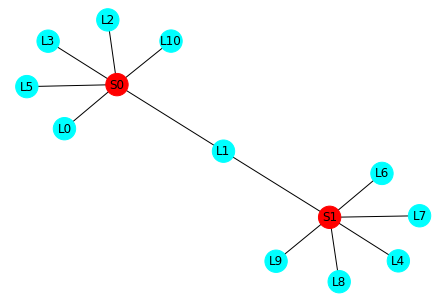

In [14]:
nviz.plot_soma_limb_concept_network(neuron_obj)

In [19]:
limb_results = pru.multi_soma_split_suggestions(neuron_obj,
                                verbose=True,
                                )

multi_soma_limbs = [1]
multi_touch_limbs = []


 -------- Working on limb 1------------
Starting combinations to process = [(38, 12)]


---- working on disconnecting 38 and 12
---- This disconnects S1_0 from S0_0  
 Cut iteration 0
Shortest path = [38, 37, 35, 31, 30, 29, 18, 12]
Found 0 high degree coordinates to cut
skip_nodes = []

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [38 37]: curr_angle = 34.42
  Edge: [37 35]: curr_angle = 6.65
  Edge: [35 31]: curr_angle = 47.13
  Edge: [31 30]: curr_angle = 29.64
  Edge: [30 29]: curr_angle = 46.72
  Edge: [29 18]: curr_angle = 24.23
  Edge: [18 12]: curr_angle = 41.82

Total time for doubling_back = 0.31182384490966797

Attempting the width jump check (attempting from both sides)
  Edge: [38 37]: jump = -92.21
  Edge: [37 35]: jump = -156.32
  Edge: [35 31]: jump = -164.34
  Edge: [31 30]: jump = 187.93
  Edge: [30 29]: jump = 155.4
  Edge: [29 18]: jump = 103.76
  Edge: [18 12]: jump = -10.63
Total time for width = 0.2772805690765381
Path starting at 38 had err_edges: []
  Edge: [12 18]: jump = 10.63
  Edge: [18 29]: jump = -103.76
  Edge: [29 30]: jump = 127.88
  Edge: [30 31]: jump = -72.9
  Edge: [31 35]: jump = 164.34
  Edge: [35 37]: jump = 156.32
  Edge: [37 38]: jump = 92.21
Total time for width = 0.2653636932373047
Path starting at 12 had err_edges: []
Did not find an error edge in either of th

In [345]:
neuron_obj = neuron.Neuron(neuron_obj)
seperate_neuron_objects = pru.split_neuron(neuron_obj)

Recieved another instance of Neuron class in init -- so just copying data
Concept graph size was 1 or less so returning original


------ Working on Soma 0 -------
Processing Neuorn in minimal output mode...please wait
Total time for neuron instance creation = 0.5169281959533691


------ Working on Soma 1 -------
Processing Neuorn in minimal output mode...please wait
Total time for neuron instance creation = 0.38280415534973145


Number of seperate neuron objects = 2

 Working on visualization type: mesh

 Working on visualization type: skeleton



 Working on visualization type: mesh

 Working on visualization type: skeleton


In [298]:
len(seperate_neuron_objects)

2

# Checking that the limbs are all connected skeletons

In [299]:
import skeleton_utils as sk

In [301]:
for n_obj in seperate_neuron_objects:
    for c_limb in n_obj:
        print(sk.number_connected_components(c_limb.skeleton))

1
1
1
1
1
1
1
1
1
1
1


# Saving of the seperated pieces

In [459]:
sep_neurons[0].save_compressed_neuron("./",
                                                 file_name="classic_double_neuron_1",
                                                 export_mesh=True)
sep_neurons[1].save_compressed_neuron("./",
                                                 file_name="classic_double_neuron_2",
                                                 export_mesh=True)

Saving Neuorn in suppress_output mode...please wait
Saved File at location: classic_double_neuron_1
Saving Neuorn in suppress_output mode...please wait
Saved File at location: classic_double_neuron_2


In [460]:
rec_neurons = [nru.decompress_neuron(f"classic_double_neuron_{k}",f"classic_double_neuron_{k}") for k in [1,2]]

for r in rec_neurons:
    nviz.visualize_neuron(r,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")

Decompressing Neuron in minimal output mode...please wait
Decompressing Neuron in minimal output mode...please wait


# Going to Now Classify Each of the Neurons

In [463]:
curr_neuron_obj = seperate_neuron_objects[0]
curr_neuron_obj

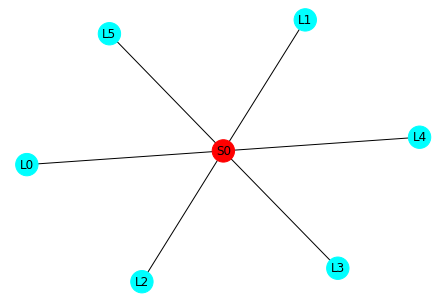

In [464]:
nviz.plot_soma_limb_concept_network(curr_neuron_obj)

In [465]:
soma_names = curr_neuron_obj.get_soma_node_names()
if len(soma_names)>1:
    raise Exception(f"More than 1 soma: {soma_names}")

soma_name = soma_names[0]

In [466]:
import neuron_statistics as nst

axon_soma_angle_threshold = 70
possible_axon_limbs = []

# Find the limb find the soma angle AND Filter away all limbs with a soma starting angle above threshold
limb_to_starting_angle = dict()
for curr_limb_idx,curr_limb in enumerate(curr_neuron_obj):
    curr_soma_angle = nst.soma_starting_angle(curr_neuron_obj,curr_limb_idx)
    limb_to_starting_angle[curr_limb_idx] = curr_soma_angle
    
    if curr_soma_angle > axon_soma_angle_threshold:
        possible_axon_limbs.append(curr_limb_idx)
    
    

limb_to_starting_angle,possible_axon_limbs

({0: 1.19, 1: 107.49, 2: 100.29, 3: 123.22, 4: 135.3, 5: 106.91},
 [1, 2, 3, 4, 5])

In [ ]:
curr_neuron_obj[4][0]

In [566]:
curr_limb = curr_neuron_obj[4][0]
nviz.plot_objects(curr_limb.mesh,
                 meshes=curr_limb.spines,
                 meshes_colors="red")

In [524]:
ret_col = nviz.visualize_neuron(curr_neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L2="all"),
                     return_color_dict=True)


 Working on visualization type: mesh

 Working on visualization type: skeleton


No limb name was given so using L2 because was the limb in the first key


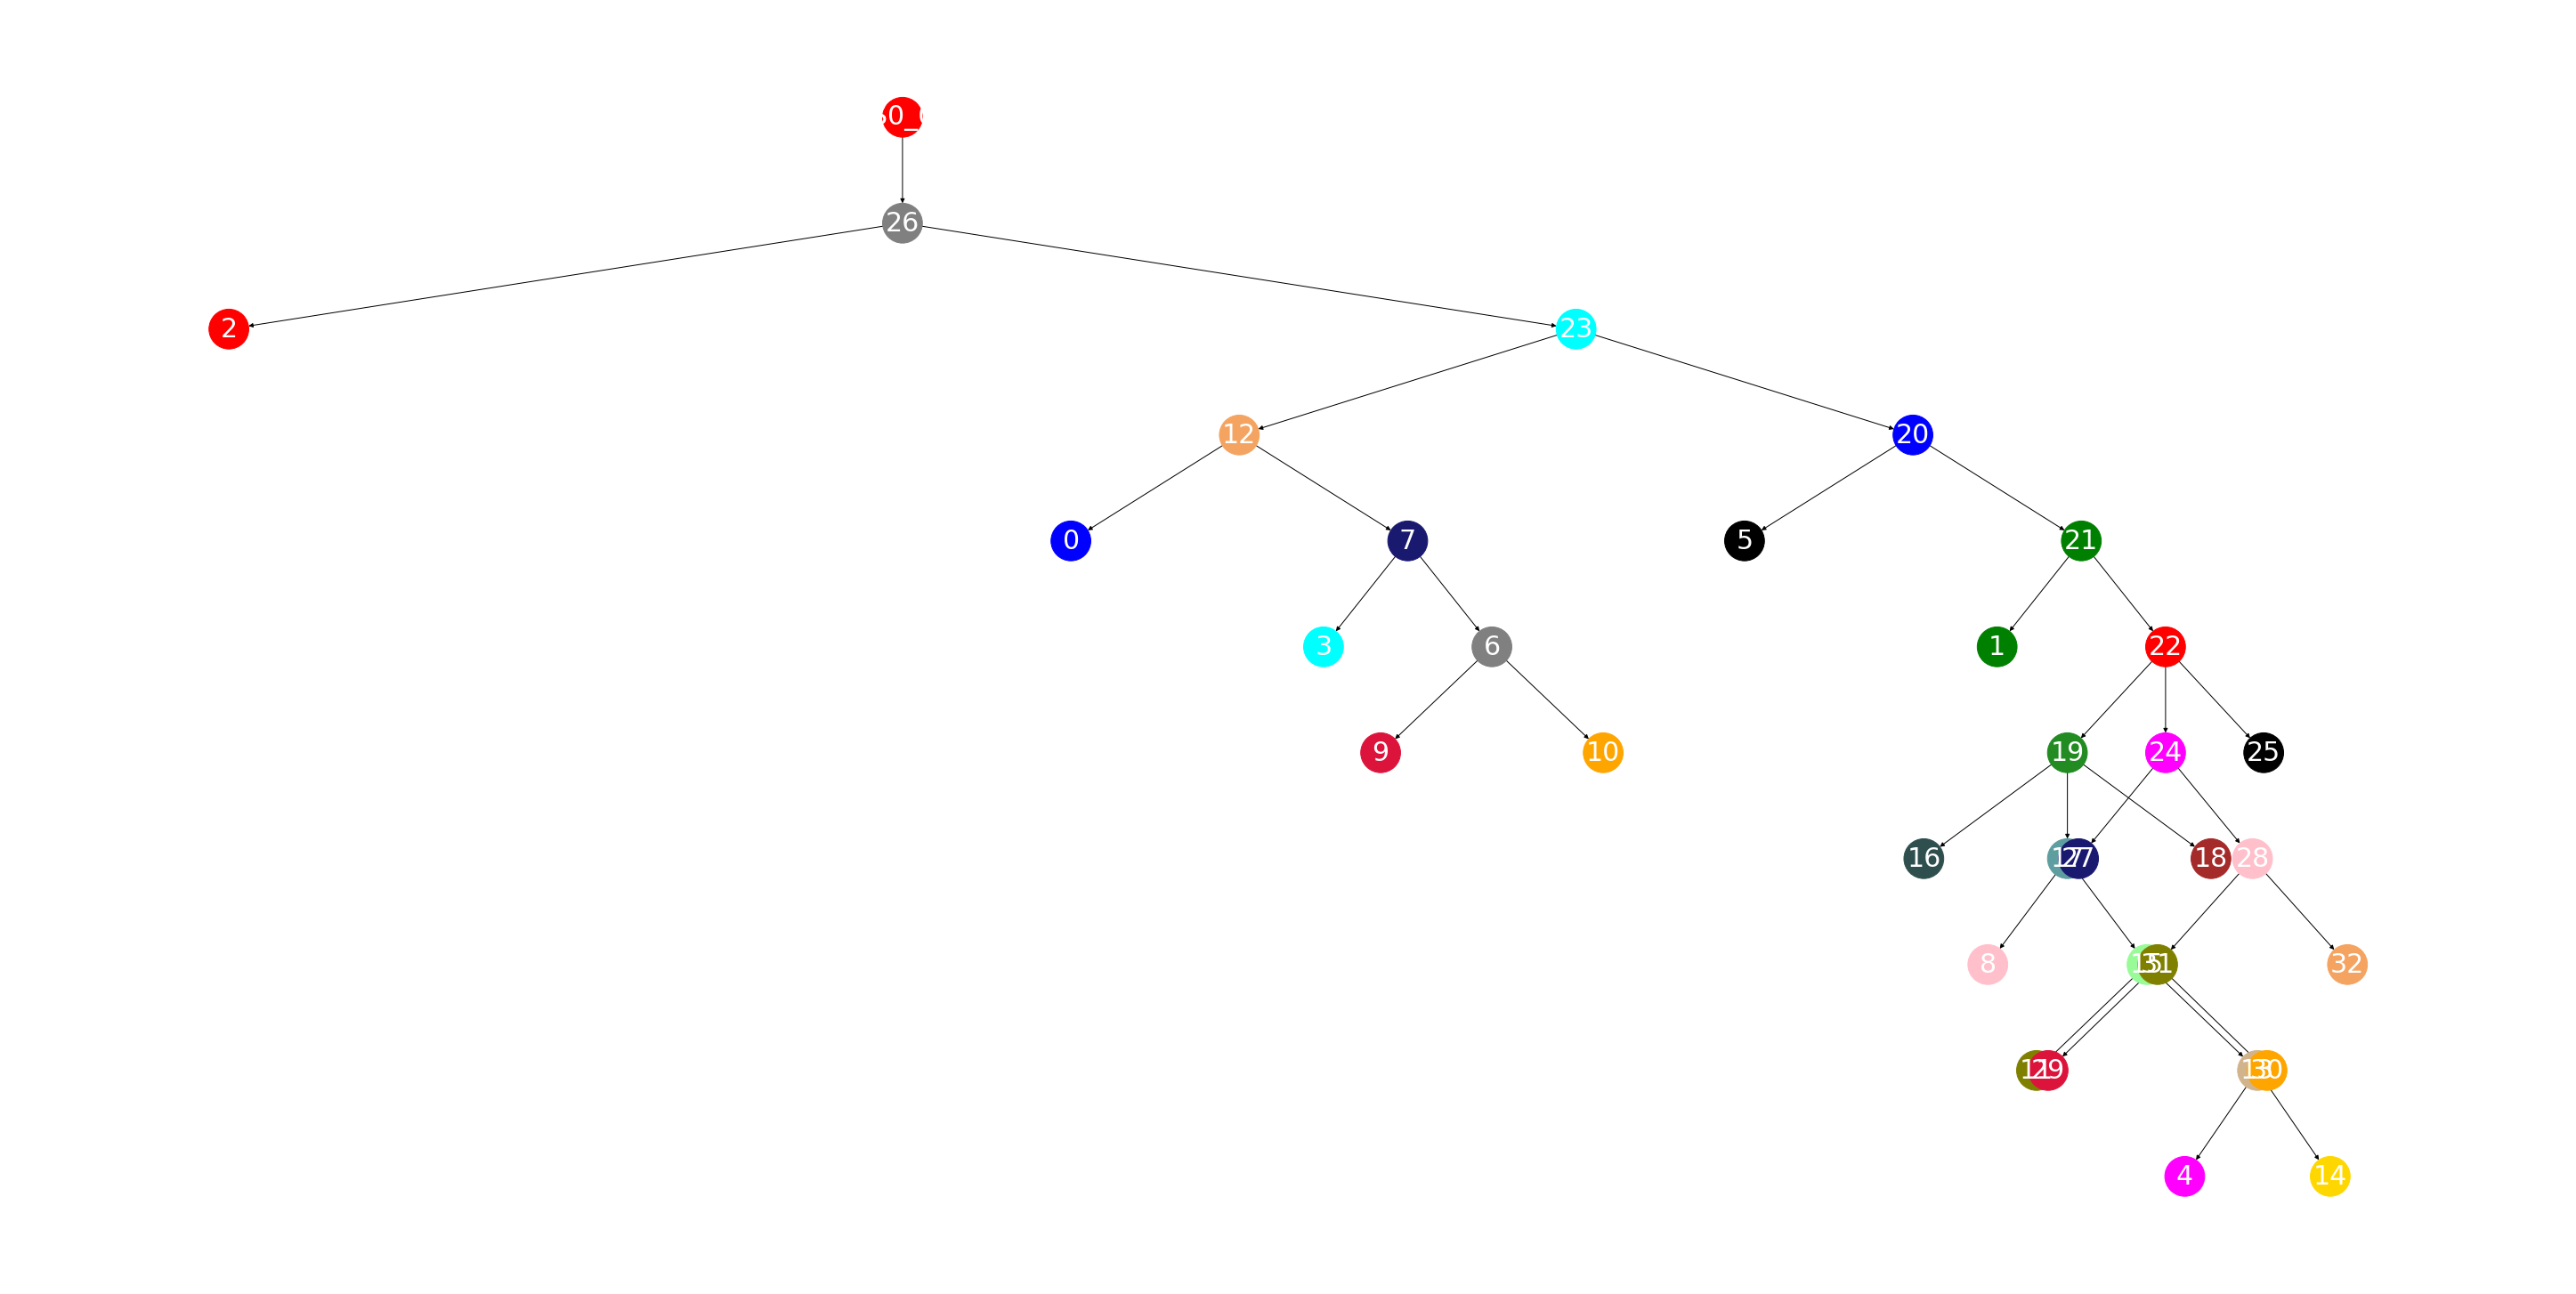

In [525]:
nviz.plot_limb_concept_network_2D(curr_neuron_obj,
                                 node_colors=ret_col)

In [526]:
ex_branch = curr_neuron_obj[2][2]
ex_branch

In [527]:
ex_branch.spines

[<trimesh.Trimesh(vertices.shape=(89, 3), faces.shape=(173, 3))>,
 <trimesh.Trimesh(vertices.shape=(42, 3), faces.shape=(79, 3))>,
 <trimesh.Trimesh(vertices.shape=(39, 3), faces.shape=(72, 3))>,
 <trimesh.Trimesh(vertices.shape=(32, 3), faces.shape=(58, 3))>,
 <trimesh.Trimesh(vertices.shape=(29, 3), faces.shape=(50, 3))>,
 <trimesh.Trimesh(vertices.shape=(17, 3), faces.shape=(29, 3))>,
 <trimesh.Trimesh(vertices.shape=(14, 3), faces.shape=(27, 3))>,
 <trimesh.Trimesh(vertices.shape=(16, 3), faces.shape=(27, 3))>,
 <trimesh.Trimesh(vertices.shape=(16, 3), faces.shape=(26, 3))>,
 <trimesh.Trimesh(vertices.shape=(15, 3), faces.shape=(25, 3))>,
 <trimesh.Trimesh(vertices.shape=(15, 3), faces.shape=(24, 3))>]

In [529]:
nviz.plot_objects(ex_branch.mesh,
                 meshes=ex_branch.spines,
                 meshes_colors="red")

In [537]:
group = tu.find_border_vertex_groups(ex_branch.mesh)
group

[[1027,
  356,
  3396,
  1254,
  1412,
  2857,
  2987,
  305,
  3220,
  3573,
  1110,
  87,
  1464,
  1339,
  637,
  383]]

In [551]:
m_skel_history = []

In [552]:
curr_root

2857

In [568]:
curr_root = group[0][12]
m_skel = sk.skeletonize_connected_branch_meshparty(curr_neuron_obj[4][0].mesh,
                                                    #ex_branch.mesh,
                                                   #root =ex_branch.mesh.vertices[curr_root],
                                                  invalidation_d=3500,
                                                  combine_close_skeleton_nodes_threshold=0,
                                                  )

100%|██████████| 1/1 [00:00<00:00, 77.94it/s]

invalidation_d = 3500
cc_vertex_thresh = 10
branches_touching_root = [1]


In [562]:
m_skel_history.append(m_skel)

In [570]:
nviz.plot_objects(curr_neuron_obj[4][0].mesh,
                  skeletons=m_skel,
                  meshes=ex_branch.spines,
                 meshes_colors="red",
                  
                 )

In [467]:
nviz.visualize_neuron(curr_neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict={f"L{k}":"all" for k in possible_axon_limbs})


 Working on visualization type: mesh

 Working on visualization type: skeleton


# Classifying all axons

In [334]:
import neuron_searching as ns

In [521]:
axon_like_limb_branch_dict = ns.axon_width_like_segments(curr_neuron_obj,
                                                        include_ais=True)

nviz.visualize_neuron(curr_neuron_obj,
                      visualize_type=["mesh"],
                     limb_branch_dict=axon_like_limb_branch_dict,
                     mesh_color="red",
                      mesh_color_alpha=1,
                     mesh_whole_neuron=True)

current_query = (n_spines < 4 and (median_mesh_center < 600) and skeleton_distance_branch <= 15000) or (skeleton_distance_branch > 15000 and (median_mesh_center < 600) and spines_per_skeletal_length < 0.00023)
functions_list = [<function width at 0x7f63c3605158>, <function median_mesh_center at 0x7f6308a792f0>, <function n_spines at 0x7f6308a79048>, <function n_faces_branch at 0x7f62a77ebb70>, <function skeleton_distance_branch at 0x7f630942bbf8>, <function spines_per_skeletal_length at 0x7f6308a79598>, <function no_spine_median_mesh_center at 0x7f6308a79400>]

 Working on visualization type: mesh


In [522]:
#How to give a limb_branch_dict as an argument
ns = reload(ns)
current_functions_list = ["axon_segment"]
final_axon_like_classification = ns.query_neuron(curr_neuron_obj,
                                        
                                   query="axon_segment==True",
                                   function_kwargs=dict(limb_branch_dict =axon_like_limb_branch_dict,
                                                        downstream_face_threshold=3000,
                                                        width_match_threshold=50,
                                                       print_flag=False),
                                   functions_list=current_functions_list)

nviz.visualize_neuron(curr_neuron_obj,
                      visualize_type=["mesh"],
                     limb_branch_dict=final_axon_like_classification,
                     mesh_color="red",
                      mesh_color_alpha=1,
                     mesh_whole_neuron=True)


functions_list = [<function axon_segment at 0x7f6308a79b70>]

 Working on visualization type: mesh


In [341]:
nviz.plot_spines(curr_neuron_obj)


 Working on visualization type: mesh

 Working on visualization type: skeleton
